# Input data analysis
This notebook provides an overview of the input data used in the TwinVECTOR summer school practical example.

In [6]:
import pandas as pd
import plotly.express as px

## Read input dataframe

In [42]:
df_inputs_initial = pd.read_csv('opt/data/timeseries/default.csv')
df_inputs_initial.head()

timestamp  dayahead_price  generation_solar  \
0  2024-01-01 00:00:00+01:00            0.10               0.0   
1  2024-01-01 01:00:00+01:00            0.01               0.0   
2  2024-01-01 02:00:00+01:00            0.02               0.0   
3  2024-01-01 03:00:00+01:00            0.00               0.0   
4  2024-01-01 04:00:00+01:00           -0.01               0.0   

   generation_wind    demand  
0         0.227844  0.550158  
1         0.281018  0.533796  
2         0.445683  0.518797  
3         0.659806  0.497736  
4         0.669240  0.493913

## Scale input data

In [43]:
df_inputs = df_inputs_initial.copy()
df_inputs['generation_solar'] = 5 * df_inputs_initial['generation_solar']
df_inputs.head()

timestamp  dayahead_price  generation_solar  \
0  2024-01-01 00:00:00+01:00            0.10               0.0   
1  2024-01-01 01:00:00+01:00            0.01               0.0   
2  2024-01-01 02:00:00+01:00            0.02               0.0   
3  2024-01-01 03:00:00+01:00            0.00               0.0   
4  2024-01-01 04:00:00+01:00           -0.01               0.0   

   generation_wind    demand  
0         0.227844  2.750791  
1         0.281018  2.668980  
2         0.445683  2.593986  
3         0.659806  2.488678  
4         0.669240  2.469564

### Define function for statistics about the data columns

In [44]:
def column_stats(df, columns):
    """
    Return basic statistics for one or more numeric columns.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame to summarize.
    columns : str or list of str
        Column name or list of column names.

    Returns
    -------
    pandas.DataFrame
        Rows = requested columns
        Columns = [min, max, mean, median, 25%, 75%, sum]
    """
    # Allow a single column name or a list
    if isinstance(columns, str):
        columns = [columns]

    # Validate columns
    missing = [c for c in columns if c not in df.columns]
    if missing:
        raise ValueError(f"Column(s) not found: {missing}")

    # Compute statistics
    result = pd.DataFrame({
        "min": df[columns].min(),
        "max": df[columns].max(),
        "mean": df[columns].mean(),
        "median": df[columns].median(),
        "25%": df[columns].quantile(0.25),
        "75%": df[columns].quantile(0.75),
        "sum": df[columns].sum()
    })

    return result

### Define function for yearly plot

In [45]:
def plot_time_series(df, column, title=None, y_label=None, color="#1f77b4", height=600):
    """
    Plot any numeric column of a DataFrame against timestamp with custom line color
    and adjustable figure height.

    Parameters
    ----------
    df : pandas.DataFrame
    column : str
        Column to plot.
    title : str, optional
    y_label : str, optional
    color : str, optional
        Hex/CSS/rgb color for the line.
    height : int, optional
        Figure height in pixels. Default = 600.
    """
    if column not in df.columns:
        raise ValueError(f"'{column}' not found in DataFrame columns: {list(df.columns)}")

    df_plot = df.reset_index() if df.index.name == "timestamp" else df

    fig = px.line(
        df_plot,
        x="timestamp",
        y=column,
        title=title or f"{column} over time",
        labels={"timestamp": "Time", column: y_label or column},
        color_discrete_sequence=[color]
    )

    fig.update_layout(
        xaxis_title="Date",
        yaxis_title=y_label or column,
        xaxis=dict(tickformat="%b\n%Y", rangeslider=dict(visible=True)),
        template="plotly_white",
        height=height
    )
    return fig

### Define function for continuous line plot

In [62]:
def plot_sorted_line(df, column, title=None, y_label=None,
                     color="#1f77b4", height=600):
    """
    Plot a continuous line of the specified column's values
    sorted in ascending order. The x-axis is the sorted index
    (0..N-1), not time.

    Parameters
    ----------
    df : pandas.DataFrame
        Data source.
    column : str
        Column to plot.
    title : str, optional
        Plot title. Defaults to 'Sorted values of <column>'.
    y_label : str, optional
        Y-axis label. Defaults to the column name.
    color : str, optional
        Line color (hex, CSS name, or rgb string). Default = '#1f77b4'.
    height : int, optional
        Figure height in pixels. Default = 600.

    Returns
    -------
    plotly.graph_objs._figure.Figure
    """
    if column not in df.columns:
        raise ValueError(f"'{column}' not found in DataFrame columns: {list(df.columns)}")

    # Sort values
    sorted_values = df[column].dropna().sort_values().reset_index(drop=True)
    plot_df = pd.DataFrame({
        "index": range(len(sorted_values)),
        column: sorted_values
    })

    fig = px.line(
        plot_df,
        x="index",
        y=column,
        title=title or f"Sorted values of {column}",
        labels={"index": "", column: y_label or column},
        color_discrete_sequence=[color]
    )

    fig.update_layout(
        xaxis_title="Sorted Position",
        yaxis_title=y_label or column,
        template="plotly_white",
        height=height
    )
    return fig

### Define function for boxplot

In [46]:
def plot_box_horizontal(df, column, title=None, x_label=None, color="#1f77b4", height=600):
    """
    Create a horizontal boxplot with custom color and adjustable figure height.

    Parameters
    ----------
    df : pandas.DataFrame
    column : str
        Column to plot.
    title : str, optional
    x_label : str, optional
    color : str, optional
        Box color.
    height : int, optional
        Figure height in pixels. Default = 600.
    """
    if column not in df.columns:
        raise ValueError(f"'{column}' not found in DataFrame columns: {list(df.columns)}")

    fig = px.box(
        df,
        x=column,
        title=title or f"Boxplot of {column}",
        labels={column: x_label or column},
        color_discrete_sequence=[color]
    )

    fig.update_layout(
        xaxis_title=x_label or column,
        yaxis=dict(showticklabels=False),
        template="plotly_white",
        height=height
    )
    return fig

### PV generation analysis

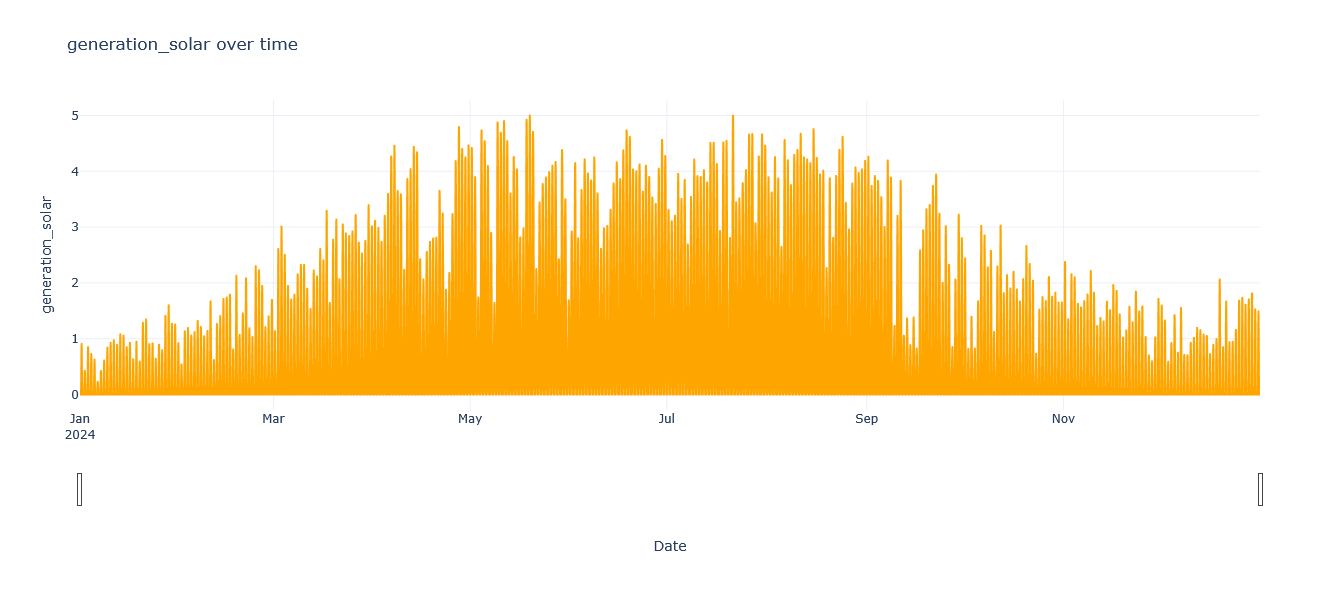

In [47]:
fig = plot_time_series(df_inputs, "generation_solar",
                       color="orange")
fig.show()

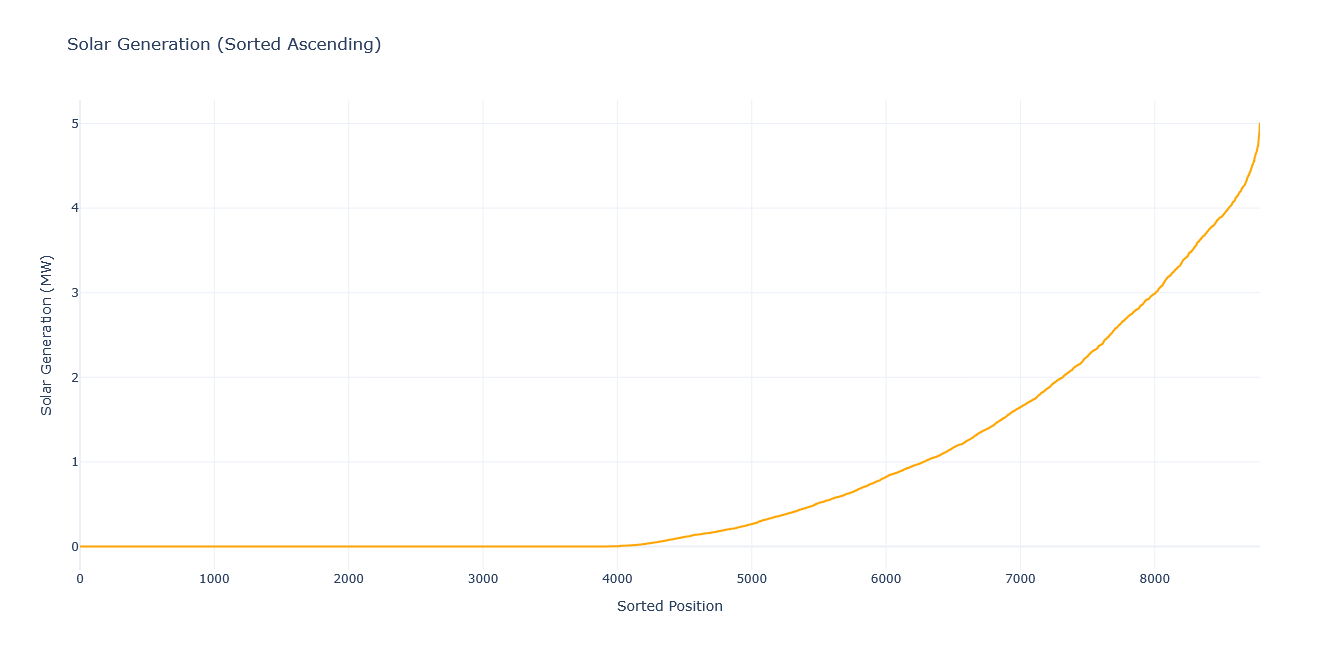

In [63]:
fig = plot_sorted_line(df_inputs,
                       column="generation_solar",
                       title="Solar Generation (Sorted Ascending)",
                       y_label="Solar Generation (MW)",
                       color="orange",
                       height=650)
fig.show()

In [48]:
stats_solar = column_stats(df_inputs, "generation_solar")
print(stats_solar)

                  min  max      mean    median  25%      75%          sum
generation_solar  0.0  5.0  0.801391  0.080587  0.0  1.23286  7039.416647


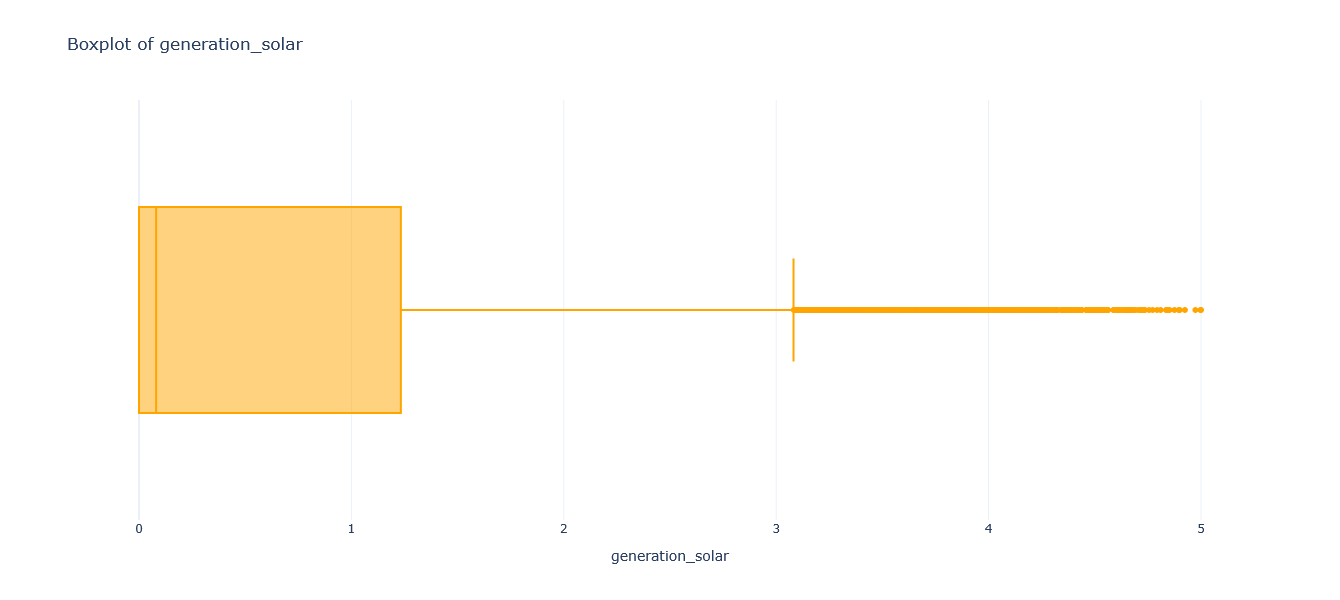

In [49]:
fig = plot_box_horizontal(df_inputs, "generation_solar",
                          color="orange") 
fig.show()

### Electricity demand analysis

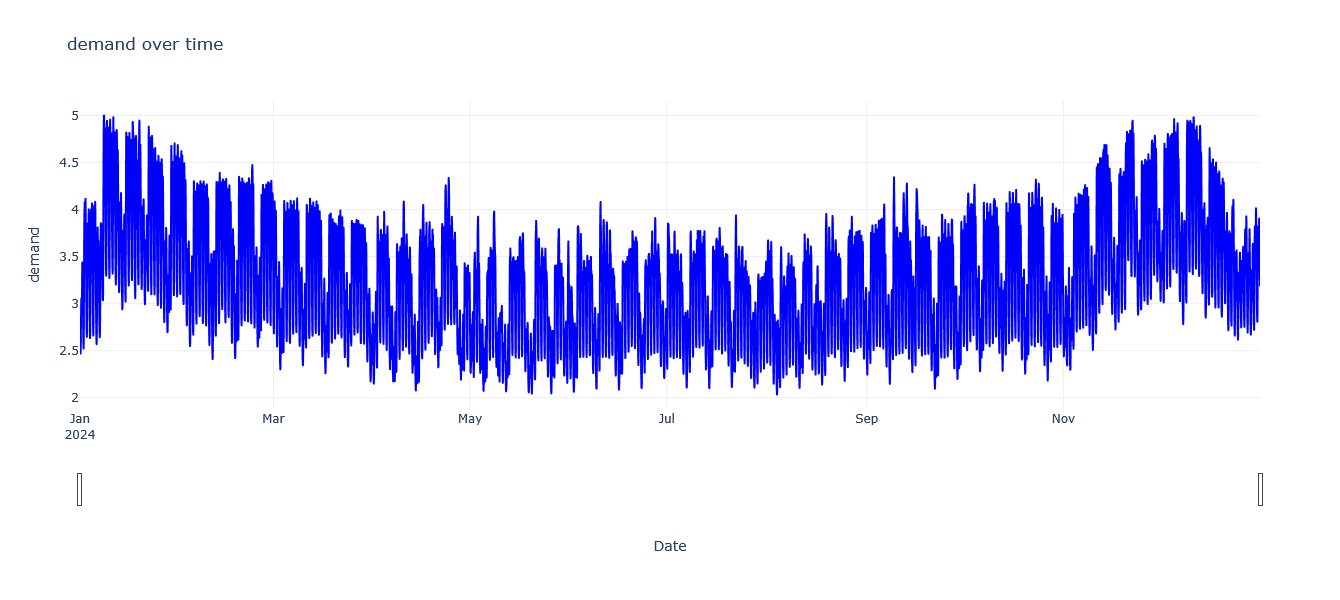

In [50]:
fig = plot_time_series(df_inputs, "demand",
                       color="blue")
fig.show()

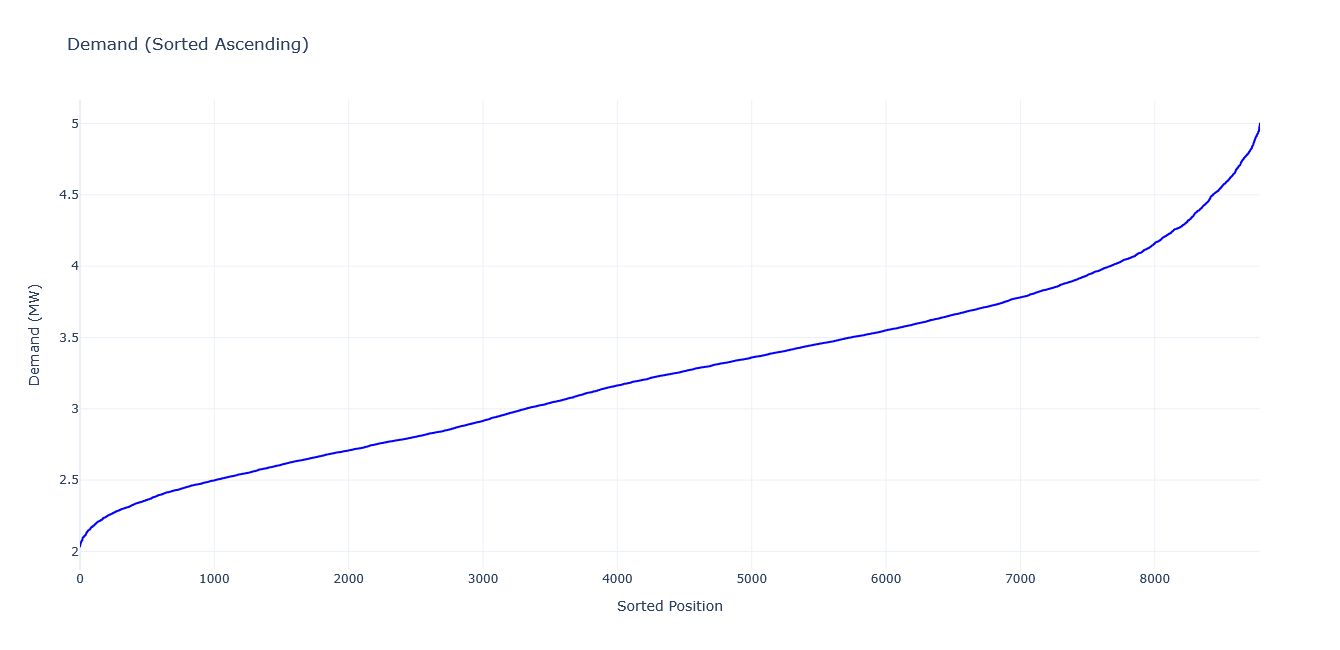

In [64]:
fig = plot_sorted_line(df_inputs,
                       column="demand",
                       title="Demand (Sorted Ascending)",
                       y_label="Demand (MW)",
                       color="blue",
                       height=650)
fig.show()

In [51]:
stats_demand = column_stats(df_inputs, "demand")
print(stats_demand)

             min  max      mean   median       25%       75%          sum
demand  2.034332  5.0  3.259863  3.24233  2.749087  3.678354  28634.63477


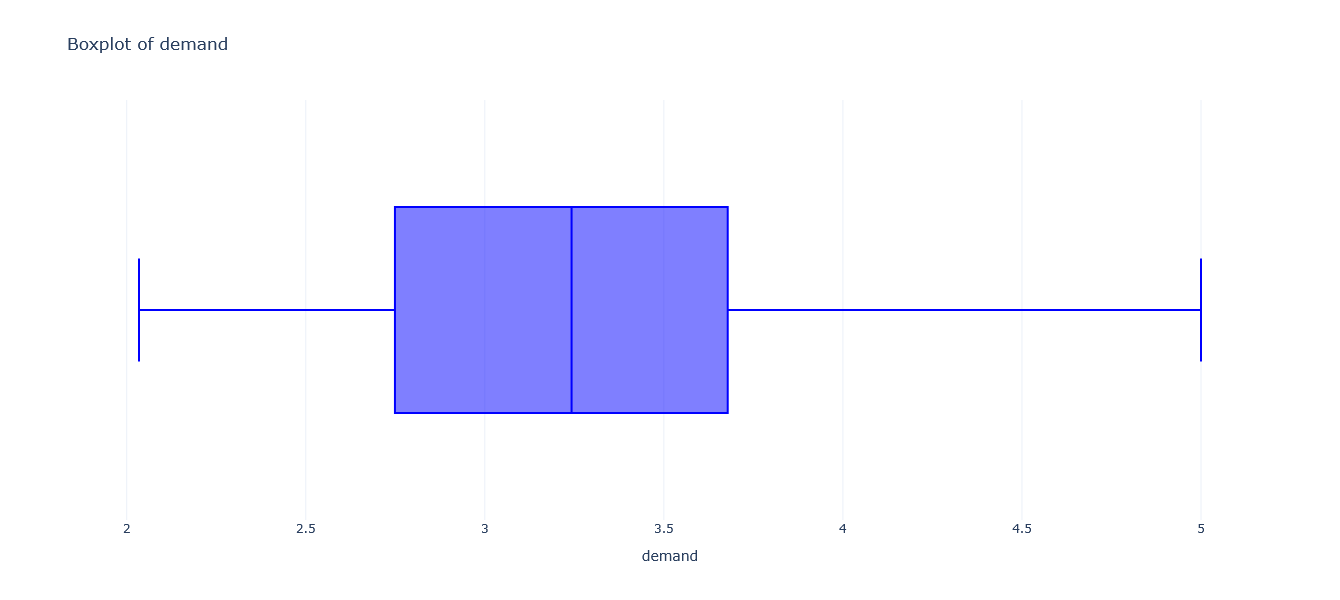

In [52]:
fig = plot_box_horizontal(df_inputs, "demand",
                          color="blue") 
fig.show()

### Day-ahead prices analysis

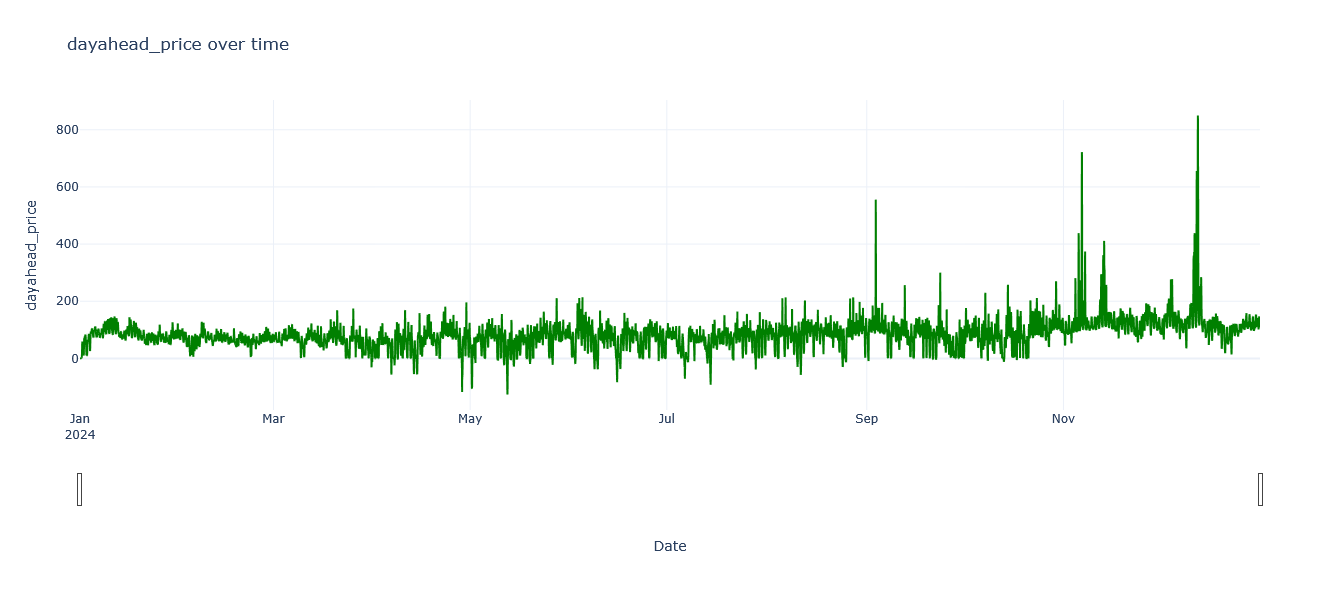

In [53]:
fig = plot_time_series(df_inputs, "dayahead_price",
                       color="green")
fig.show()

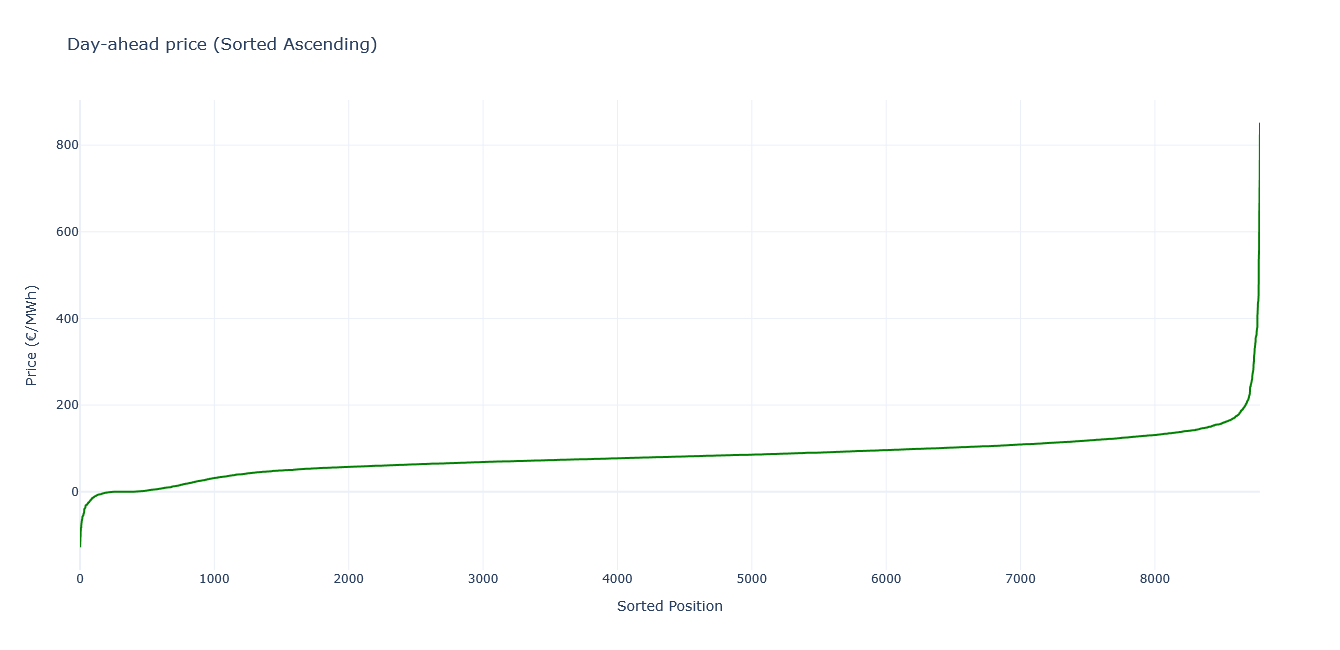

In [65]:
fig = plot_sorted_line(df_inputs,
                       column="dayahead_price",
                       title="Day-ahead price (Sorted Ascending)",
                       y_label="Price (€/MWh)",
                       color="green",
                       height=650)
fig.show()

In [54]:
stats_prices = column_stats(df_inputs, "dayahead_price")
print(stats_prices)

                   min    max       mean  median    25%    75%       sum
dayahead_price -126.42  850.0  81.534282   80.49  59.84  103.0  716115.6


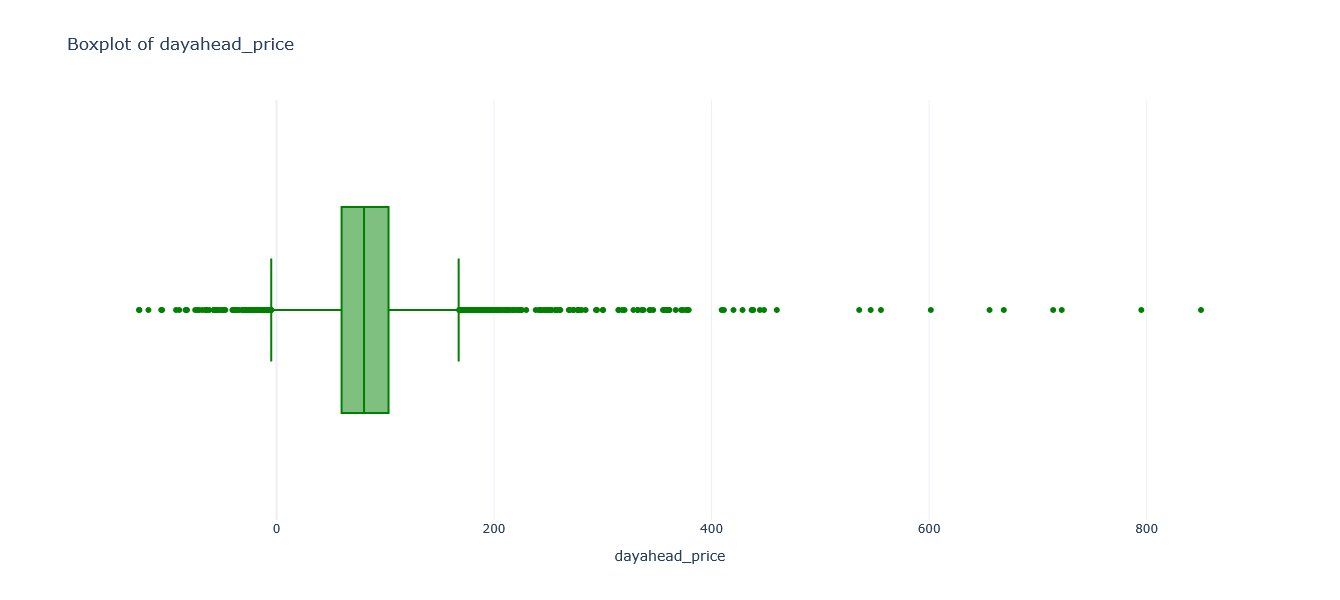

In [55]:
fig = plot_box_horizontal(df_inputs, "dayahead_price",
                          color="green") 
fig.show()